In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier



In [2]:
account = pd.read_excel("account.xlsx")
card = pd.read_excel("card.xlsx")
client = pd.read_excel("client.xlsx")
disp = pd.read_excel("disp.xlsx")
district = pd.read_excel("district.xlsx")
loan = pd.read_excel("loan.xlsx")
order = pd.read_excel("order.xlsx")
trans = pd.read_excel("trans.xlsx")

Pliki zostały przeanalizowane i oczyszczone podczas pracy nad częścią pierwszą projektu w Power Query. Następnie wyeksportowane i załadowane do środowiska Pythona.

In [3]:
trans["account"] = trans["account"].astype("Int64")
# Konwersja dat
loan['granted_date_loan'] = pd.to_datetime(loan['granted_date_loan'], dayfirst=True, errors='coerce')
client['birth_date'] = pd.to_datetime(client['birth_date'], dayfirst=True, errors='coerce')

In [34]:
# Sprawdzenie liczby braków w granted_date_loan i birth_date
print("Pożyczki z brakującą datą:", loan['granted_date_loan'].isna().sum())
print("Daty urodzenia z brakującą datą:", client['birth_date'].isna().sum())

Pożyczki z brakującą datą: 0
Daty urodzenia z brakującą datą: 0


In [5]:
# Łączenie tabel
loans_df = loan.copy()
loans_df = pd.merge(loans_df, disp[['disp_id','client_id','account_id']], on='account_id', how='left')
loans_df = pd.merge(loans_df, client, on='client_id', how='left')
loans_df = pd.merge(loans_df, district[['district_id','region','Average Salary']], left_on='district_id', right_on='district_id', how='left')
# Obliczenie wieku w momencie pożyczki
loans_df['age_at_loan'] = (loans_df['granted_date_loan'] - loans_df['birth_date']).dt.days // 365
#Tworzenie zmiennej opisowej (targetu) (1 = niespłacona, 0 = spłacona) ---
loans_df['target'] = loans_df['status'].apply(lambda x: 1 if x in ['B','D'] else 0)
#Sprawdzenie liczby pożyczek niespłaconych
print("Liczba pożyczek niespłaconych:", loans_df['target'].sum())
print("Liczba wszystkich pożyczek:", len(loans_df))

Liczba pożyczek niespłaconych: 76
Liczba wszystkich pożyczek: 827


In [6]:
#Agregacja transakcji po koncie
trans_agg = trans.groupby('account_id').agg(
    num_transactions=('trans_id', 'count'),
    total_trans_amount=('amount', 'sum'),
    avg_trans_amount=('amount', 'mean')
).reset_index()
#Łączenie z loans_df
loans_df = pd.merge(loans_df, trans_agg, on='account_id', how='left')
#Wypełnienie braków 0 (dla kont bez transakcji)
loans_df[['num_transactions', 'total_trans_amount', 'avg_trans_amount']] = loans_df[['num_transactions', 'total_trans_amount', 'avg_trans_amount']].fillna(0)
#Sprawdzenie ile pożyczek ma transakcje > 0
print("Pożyczki z transakcjami >0:", (loans_df['num_transactions']>0).sum())

Pożyczki z transakcjami >0: 827


In [7]:
loans_df.head(10)

,loan_id,account_id,amount,duration,payments,status,granted_date_loan,disp_id,client_id,district_id,gender,birth_date,region,Average Salary,age_at_loan,target,num_transactions,total_trans_amount,avg_trans_amount
0,5170,1071,253200,60,4220,C,1994-01-20,1286,1286,52,Woman,1950-03-13,East Bohemia,8363,43,0,392,6099458,15559.841837
1,6087,5313,300660,60,5011,C,1994-02-27,6417,6417,40,Man,1950-01-07,North Bohemia,9317,44,0,600,7685198,12808.663333
2,7055,10079,167100,60,2785,C,1994-04-06,12088,12396,62,Woman,1970-01-17,South Moravia,8544,24,0,437,6863649,15706.290618
3,7055,10079,167100,60,2785,C,1994-04-06,12089,12397,62,Man,1973-06-02,South Moravia,8544,20,0,437,6863649,15706.290618
4,6103,5385,149340,60,2489,C,1994-04-07,6499,6499,44,Man,1963-02-01,East Bohemia,8254,31,0,426,3689981,8661.927230
5,6696,8321,89040,60,1484,C,1994-05-09,9967,10275,77,Woman,1970-01-25,North Moravia,8909,24,0,532,1946142,3658.161654
6,6696,8321,89040,60,1484,C,1994-05-09,9968,10276,77,Man,1976-11-16,North Moravia,8909,17,0,532,1946142,3658.161654
7,5568,2933,272520,60,4542,C,1994-05-17,3542,3542,10,Man,1939-09-02,Central Bohemia,10124,54,0,472,5123858,10855.631356
8,5568,2933,272520,60,4542,C,1994-05-17,3543,3543,10,Woman,1941-08-19,Central Bohemia,10124,52,0,472,5123858,10855.631356
9,6736,8558,288360,60,4806,C,1994-06-14,10247,10555,1,Man,1935-12-15,Prague,12541,58,0,335,18658973,55698.426866


In [8]:
loans_df.info()
loans_df.describe()

#Sprawdzenie brakujących wartości w loans_df
loans_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827 entries, 0 to 826
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   loan_id             827 non-null    int64         
 1   account_id          827 non-null    int64         
 2   amount              827 non-null    int64         
 3   duration            827 non-null    int64         
 4   payments            827 non-null    int64         
 5   status              827 non-null    object        
 6   granted_date_loan   827 non-null    datetime64[ns]
 7   disp_id             827 non-null    int64         
 8   client_id           827 non-null    int64         
 9   district_id         827 non-null    int64         
 10  gender              827 non-null    object        
 11  birth_date          827 non-null    datetime64[ns]
 12  region              827 non-null    object        
 13  Average Salary      827 non-null    int64         

loan_id               0
account_id            0
amount                0
duration              0
payments              0
status                0
granted_date_loan     0
disp_id               0
client_id             0
district_id           0
gender                0
birth_date            0
region                0
Average Salary        0
age_at_loan           0
target                0
num_transactions      0
total_trans_amount    0
avg_trans_amount      0
dtype: int64

Wszystkie kolumny mają pełne wypełnienie (Non-Null Count = 827), co oznacza, że nie występują brakujące wartości. Typy danych są poprawnie rozpoznane: wartości liczbowe są w formacie int64 lub float64, daty w formacie datetime64, a zmienne kategoryczne jako object. Dane są gotowe do dalszej analizy.

In [9]:
# Wybór kolumn numerycznych
numeric_cols = ['age_at_loan', 'amount', 'duration', 'payments', 
                'Average Salary', 'num_transactions', 'total_trans_amount', 'avg_trans_amount', 'target']
print(loans_df[numeric_cols].describe())

       age_at_loan         amount    duration     payments  Average Salary  \
count   827.000000     827.000000  827.000000   827.000000      827.000000   
mean     37.853688  151801.538089   36.261185  4231.251511     9462.871826   
std      13.089712  114577.041848   17.172800  2238.757849     1314.143218   
min       7.000000    4980.000000   12.000000   304.000000     8110.000000   
25%      27.000000   67536.000000   24.000000  2495.500000     8541.000000   
50%      37.000000  115992.000000   36.000000  3937.000000     8965.000000   
75%      49.000000  210564.000000   48.000000  5916.000000     9897.000000   
max      63.000000  590820.000000   60.000000  9910.000000    12541.000000   

       num_transactions  total_trans_amount  avg_trans_amount      target  
count        827.000000        8.270000e+02        827.000000  827.000000  
mean         280.379686        6.317585e+06      23288.912488    0.091898  
std          136.788090        1.292116e+07      47796.755536    0.28

amount, duration, payments, Average Salary – wartości mieszczą się w rozsądnych zakresach. Mediany i kwartyle pokazują typowe wartości dla większości klientów, natomiast min/max wskazują obecność kilku skrajnych przypadków (np. bardzo niskie lub bardzo wysokie kwoty pożyczek.
age_at_loan - minimalny wiek 7 lat – będzie sprawdzany w kolejnych krokach.

num_transactions, total_trans_amount, avg_trans_amount – średnie wartości wskazują, że większość klientów ma umiarkowaną liczbę transakcji i ich sumy. Natomiast duże odchylenia standardowe i maksima pokazują, że niektórzy klienci mają znacznie wyższe aktywności transakcyjne.

target – średnia 0,092 oznacza, że około 9% pożyczek jest niespłaconych, co odpowiada wartościom w danych źródłowych.

In [10]:
# Liczba pożyczek, gdzie wiek klienta jest poniżej 18 lat
num_underage_loans = (loans_df['age_at_loan'] < 18).sum()
print("Liczba pożyczek z wiekiem poniżej 18 lat:", num_underage_loans)

Liczba pożyczek z wiekiem poniżej 18 lat: 43


In [11]:
# Liczba pożyczek, gdzie wiek klienta jest poniżej 17 lat
num_underage_loans = (loans_df['age_at_loan'] < 17).sum()
print("Liczba pożyczek z wiekiem poniżej 17 lat:", num_underage_loans)

Liczba pożyczek z wiekiem poniżej 17 lat: 25


Żeby poprawić wiarygodność modeli, usunięte zostaną wiersze, gdzie wiek klienta jest mniejszy niż 17 lat, ponieważ w wielu przypadkach 17 letni klienci rocznikowo są już pełnoletni.

In [38]:
# Usunięcie wierszy, gdzie wiek klienta jest mniejszy niż 17 lat
loans_df = loans_df[loans_df['age_at_loan'] >= 17].copy()

# Sprawdzenie nowego rozmiaru zbioru
print("Liczba pożyczek niespłaconych:", loans_df['target'].sum())
print("Liczba wszystkich pożyczek:", len(loans_df))


Liczba pożyczek niespłaconych: 74
Liczba wszystkich pożyczek: 802


In [13]:
print(loans_df[numeric_cols].describe())

       age_at_loan         amount    duration     payments  Average Salary  \
count   802.000000     802.000000  802.000000   802.000000      802.000000   
mean     38.584788  150784.698254   36.239401  4215.250623     9460.441397   
std      12.604457  114351.105449   17.127051  2251.600453     1315.479387   
min      17.000000    4980.000000   12.000000   304.000000     8110.000000   
25%      28.000000   66960.000000   24.000000  2482.000000     8541.000000   
50%      38.000000  114804.000000   36.000000  3891.500000     8965.000000   
75%      50.000000  208320.000000   48.000000  5912.500000     9897.000000   
max      63.000000  590820.000000   60.000000  9910.000000    12541.000000   

       num_transactions  total_trans_amount  avg_trans_amount      target  
count        802.000000        8.020000e+02        802.000000  802.000000  
mean         276.346633        6.243864e+06      23249.079983    0.092269  
std          134.828858        1.300223e+07      48214.601536    0.28

In [14]:
#Sprawdzenie brakujących wartości w loans_df
loans_df.isna().sum()

loan_id               0
account_id            0
amount                0
duration              0
payments              0
status                0
granted_date_loan     0
disp_id               0
client_id             0
district_id           0
gender                0
birth_date            0
region                0
Average Salary        0
age_at_loan           0
target                0
num_transactions      0
total_trans_amount    0
avg_trans_amount      0
dtype: int64

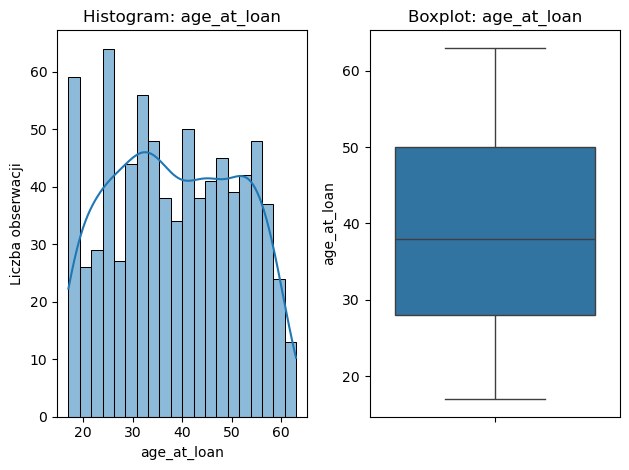

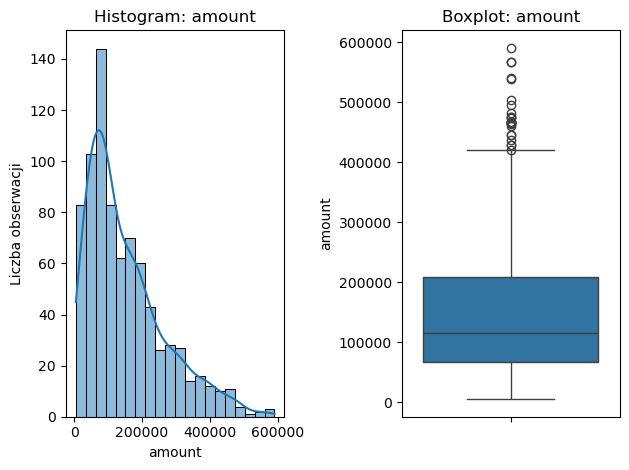

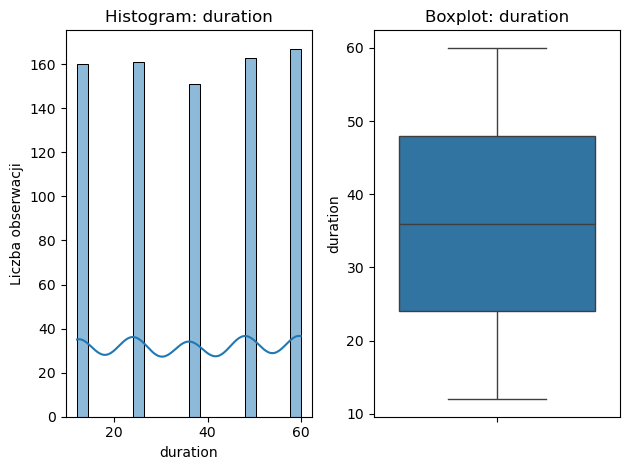

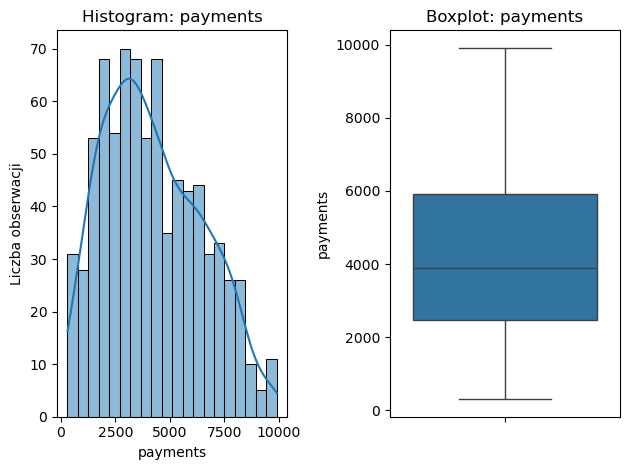

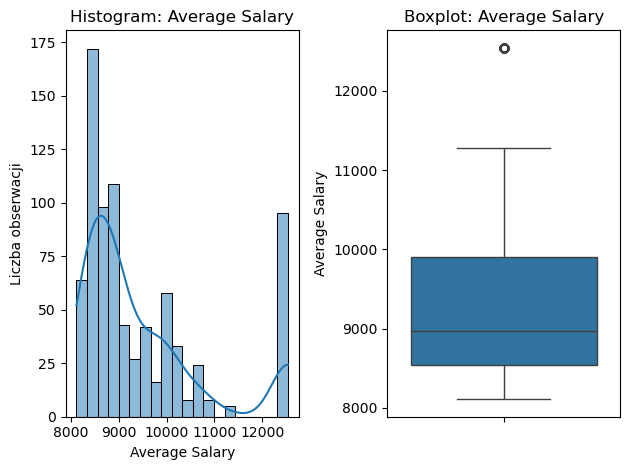

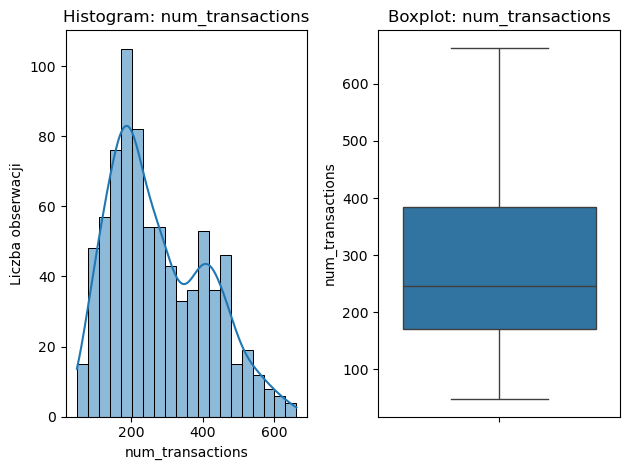

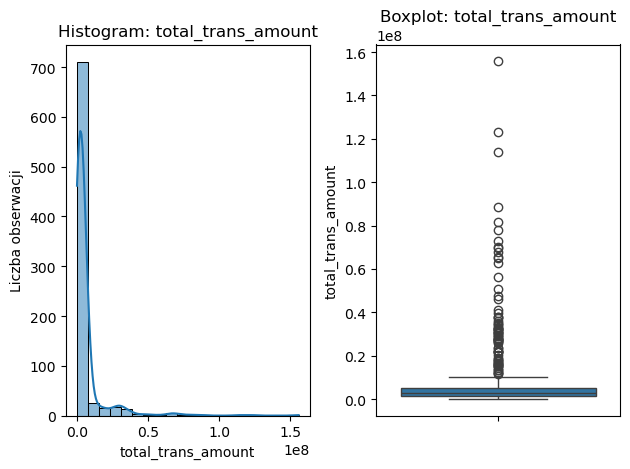

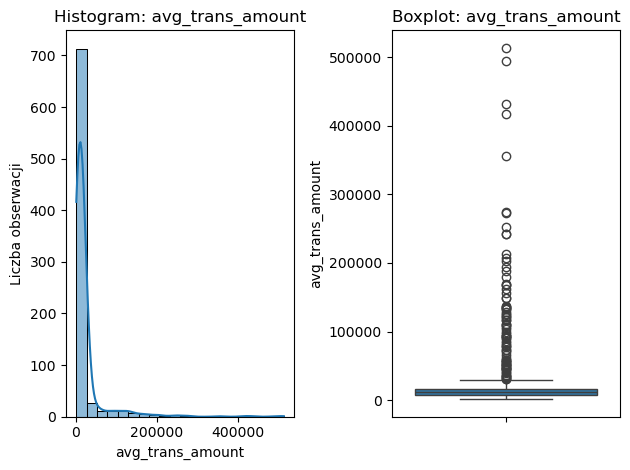

In [15]:
# Analiza rozkładu zmiennych
# Lista zmiennych numerycznych
numeric_cols = ['age_at_loan', 'amount', 'duration', 'payments', 
                'Average Salary', 'num_transactions', 'total_trans_amount', 'avg_trans_amount']

for col in numeric_cols:
    plt.figure()
    
    # Histogram
    plt.subplot(1,2,1)
    sns.histplot(loans_df[col], bins=20, kde=True)
    plt.xlabel(col)
    plt.ylabel('Liczba obserwacji')
    plt.title(f'Histogram: {col}')
    
    # Boxplot pionowy
    plt.subplot(1,2,2)
    sns.boxplot(y=loans_df[col])
    plt.ylabel(col)
    plt.title(f'Boxplot: {col}')
    
    plt.tight_layout()
    plt.show()

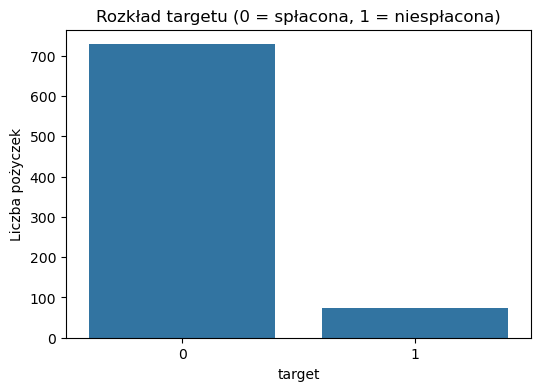

In [16]:
plt.figure(figsize=(6,4))
sns.countplot(x=loans_df['target'])
plt.title("Rozkład targetu (0 = spłacona, 1 = niespłacona)")
plt.xlabel("target")
plt.ylabel("Liczba pożyczek")
plt.show()

Analiza rozkładu zmiennych:

age_at_loan - rozkład naturalny: 18–60 lat Brak wartości odstających, co oznacza, że nie ma błędów w datach Mediana ok 47 - pożyczki biorą głównie osoby w średnim wieku.

amount - rozkład prawoskosny - większość pożyczek ma mniejsze kwoty, a kilka jest bardzo dużych Boxplot potwierdza obecność outlierów Mediana ok 100k - typowa.

duration - rozkład skupiony w kilku najczęściej wybieranych okresach kredytowania brak odstających wartości – typowe długości pożyczek.

payments - rozkład prawoskosny - większość wartości skupiona jest przy niższych kwotach, a ogon rozciąga się w prawo. Mediana wynosi około 4000. Brak wyraźnych wartości odstających.

average salary - zarobki większości klientów mieszczą się w przedziale 8–11 tys. zł, pojedyncze osoby zarabiają znacznie więcej. Jeden outlier (ok 15k) Mediana ok 9k.

num_transactions - sugeruje dwie grupy klientów: większość wykonuje około 150–250 transakcji, a mniejsza grupa ma wyższą aktywność (350–450). Mediana ok 250 potwierdza typowy poziom aktywności. Brak wartości odstających oznacza, że dane są stabilne.

total_trans_amount - wyraźna prawoskośność – większość klientów wykonuje niskie łączne kwoty transakcji. Boxplot: Wiele wysokich wartości odstających (klienci bardzo aktywni finansowo).

avg_trans_amount - Podobny do total_trans_amount – kilka wysokich wartości podciąga rozkład w prawo.

rozkład targetu - większość pożyczek została spłacona (ponad 700 przypadków), a niespłaconych jest mniej niż 100. Oznacza to, że klasa „1” stanowi tylko niewielką część danych.

In [17]:
#Sprawdzenie korelacji
#Lista zmiennych ciągłych
continuous_features = [
    "age_at_loan", 
    "amount", 
    "duration", 
    "payments", 
    "Average Salary",
    "num_transactions", 
    "total_trans_amount", 
    "avg_trans_amount"
]

#Korelacja zmiennych ciągłych z target
corr_with_target = loans_df[continuous_features + ["target"]].corr()["target"].sort_values(ascending=False)
print(corr_with_target)

target                1.000000
total_trans_amount    0.502678
avg_trans_amount      0.477615
payments              0.149833
amount                0.149651
num_transactions      0.042378
duration              0.031787
age_at_loan          -0.010697
Average Salary       -0.022041
Name: target, dtype: float64


In [18]:
# Średnie prawdopodobieństwo niespłaty w zależności od kategorii
print(loans_df.groupby("gender")["target"].mean())
print(loans_df.groupby("region")["target"].mean())

gender
Man      0.087940
Woman    0.096535
Name: target, dtype: float64
region
Central Bohemia    0.098901
East Bohemia       0.066038
North Bohemia      0.013889
North Moravia      0.139706
Prague             0.063158
South Bohemia      0.120000
South Moravia      0.094340
West Bohemia       0.117647
Name: target, dtype: float64


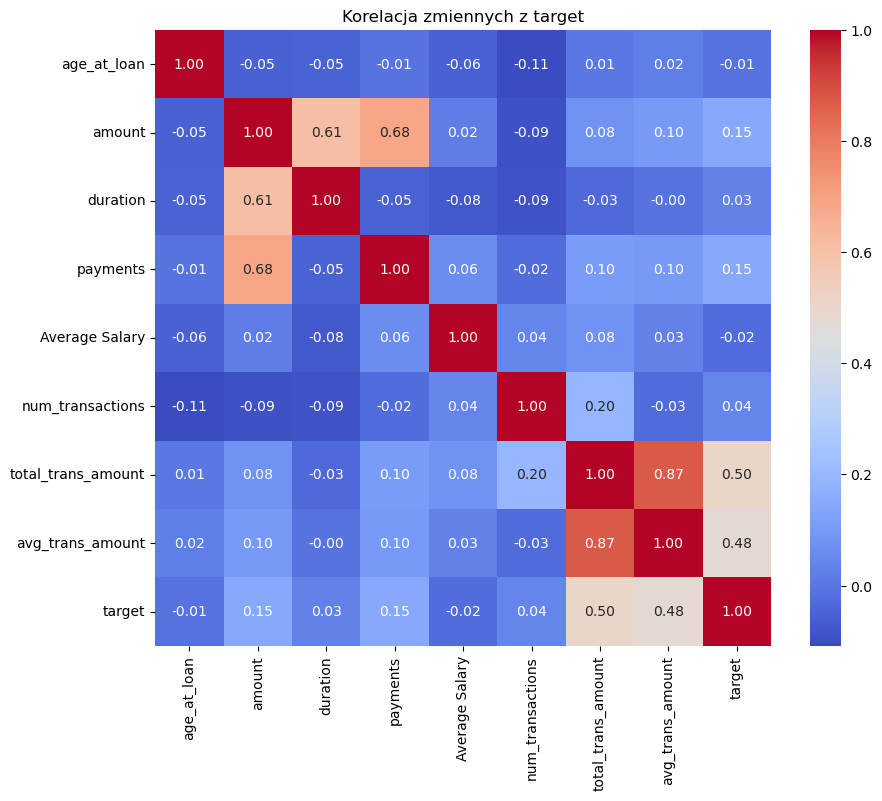

In [19]:
continuous_features = ["age_at_loan", "amount", "duration", "payments",
                       "Average Salary", "num_transactions", "total_trans_amount",
                       "avg_trans_amount", "target"]

corr_matrix = loans_df[continuous_features].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Korelacja zmiennych z target")
plt.show()

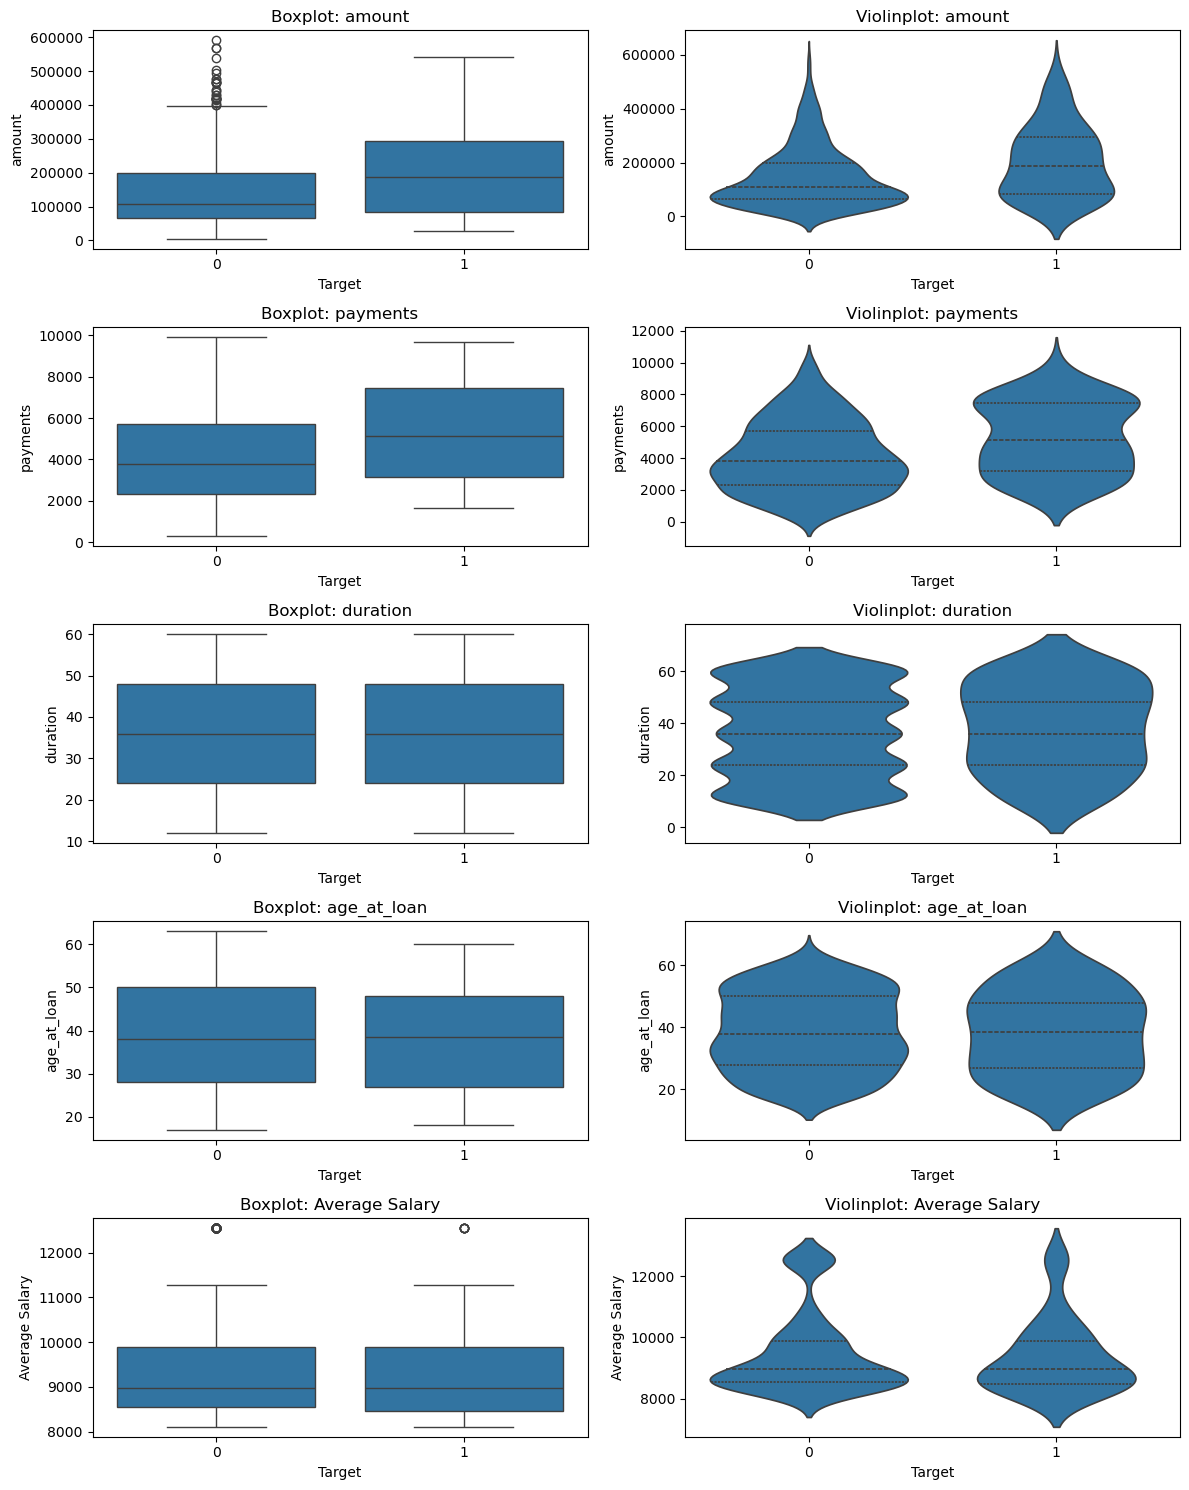

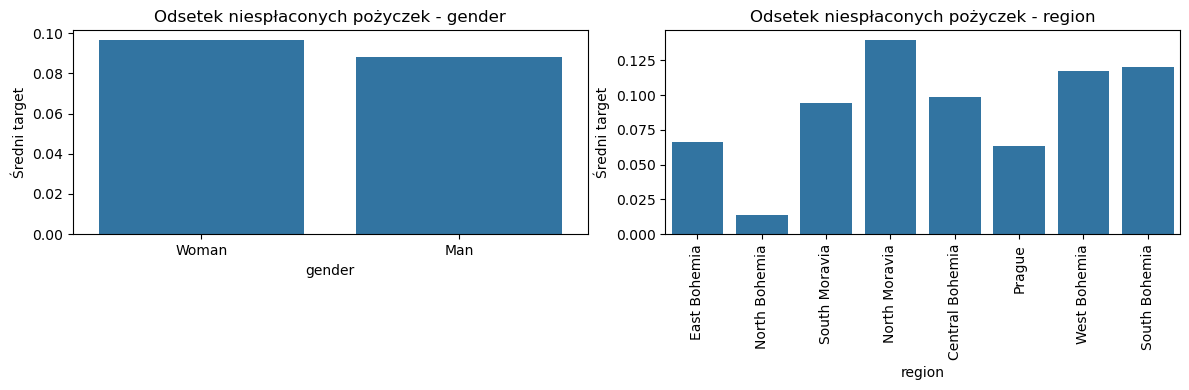

In [20]:
#Wizualizacja zależności między cechami klientów a niespłaceniem kredytu
# Zmienne numeryczne
num_cols = ['amount', 'payments', 'duration', 'age_at_loan', 'Average Salary']

# Boxploty i violinploty
fig, axes = plt.subplots(len(num_cols), 2, figsize=(12, len(num_cols)*3))
for i, col in enumerate(num_cols):
    sns.boxplot(x='target', y=col, data=loans_df, ax=axes[i,0])
    axes[i,0].set_title(f'Boxplot: {col}')
    axes[i,0].set_xlabel('Target')
    axes[i,0].set_ylabel(col)
    
    sns.violinplot(x='target', y=col, data=loans_df, inner='quartile', ax=axes[i,1])
    axes[i,1].set_title(f'Violinplot: {col}')
    axes[i,1].set_xlabel('Target')
    axes[i,1].set_ylabel(col)

plt.tight_layout()
plt.show()

# Zmienne kategoryczne
cat_cols = ['gender', 'region']

fig, axes = plt.subplots(1, len(cat_cols), figsize=(12,4))
for i, col in enumerate(cat_cols):
    sns.barplot(x=col, y='target', data=loans_df, errorbar=None, ax=axes[i])
    axes[i].set_title(f'Odsetek niespłaconych pożyczek - {col}')
    axes[i].set_ylabel('Średni target')
    if col == 'region':
        plt.setp(axes[i].get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

Najsilniejsze powiązania z niespłaceniem pożyczki występują dla total_trans_amount i avg_trans_amount (umiarkowane dodatnie korelacje). Klienci wykonujący transakcje o wyższych kwotach częściej trafiają do grupy niespłacającej. Kwota pożyczki i wysokość raty mają słabe, ale dodatnie korelacje z ryzykiem niewypłacalności. Pozostałe zmienne liczbowe praktycznie nie wpływają na target.

Zmienne kategoryczne (płeć, region) wykazują jedynie bardzo słabe zależności – różnice między grupami są niewielkie, więc nie stanowią istotnych czynników ryzyka.

In [21]:
#Stworzenie kopii danych do modelowania i kodowanie zmiennych kategorycznych
loans_model_df = loans_df.copy()

cat_cols = ['gender', 'region']

loans_model_df = pd.get_dummies(loans_model_df, 
                                columns=cat_cols, 
                                drop_first=True)

loans_model_df.head(10)

,loan_id,account_id,amount,duration,payments,status,granted_date_loan,disp_id,client_id,district_id,...,total_trans_amount,avg_trans_amount,gender_Woman,region_East Bohemia,region_North Bohemia,region_North Moravia,region_Prague,region_South Bohemia,region_South Moravia,region_West Bohemia
0,5170,1071,253200,60,4220,C,1994-01-20,1286,1286,52,...,6099458,15559.841837,True,True,False,False,False,False,False,False
1,6087,5313,300660,60,5011,C,1994-02-27,6417,6417,40,...,7685198,12808.663333,False,False,True,False,False,False,False,False
2,7055,10079,167100,60,2785,C,1994-04-06,12088,12396,62,...,6863649,15706.290618,True,False,False,False,False,False,True,False
3,7055,10079,167100,60,2785,C,1994-04-06,12089,12397,62,...,6863649,15706.290618,False,False,False,False,False,False,True,False
4,6103,5385,149340,60,2489,C,1994-04-07,6499,6499,44,...,3689981,8661.927230,False,True,False,False,False,False,False,False
5,6696,8321,89040,60,1484,C,1994-05-09,9967,10275,77,...,1946142,3658.161654,True,False,False,True,False,False,False,False
6,6696,8321,89040,60,1484,C,1994-05-09,9968,10276,77,...,1946142,3658.161654,False,False,False,True,False,False,False,False
7,5568,2933,272520,60,4542,C,1994-05-17,3542,3542,10,...,5123858,10855.631356,False,False,False,False,False,False,False,False
8,5568,2933,272520,60,4542,C,1994-05-17,3543,3543,10,...,5123858,10855.631356,True,False,False,False,False,False,False,False
9,6736,8558,288360,60,4806,C,1994-06-14,10247,10555,1,...,18658973,55698.426866,False,False,False,False,True,False,False,False


In [22]:
# Lista kolumn do usunięcia
cols_to_drop = [
    'loan_id',
    'account_id',
    'disp_id',
    'client_id',
    'district_id',
    'granted_date_loan',
    'birth_date',
    'status'
]

# Usunięcie kolumn
loans_model_df = loans_model_df.drop(columns=cols_to_drop, errors='ignore')

# Sprawdzenie efektu
loans_model_df.head()


,amount,duration,payments,Average Salary,age_at_loan,target,num_transactions,total_trans_amount,avg_trans_amount,gender_Woman,region_East Bohemia,region_North Bohemia,region_North Moravia,region_Prague,region_South Bohemia,region_South Moravia,region_West Bohemia
0,253200,60,4220,8363,43,0,392,6099458,15559.841837,True,True,False,False,False,False,False,False
1,300660,60,5011,9317,44,0,600,7685198,12808.663333,False,False,True,False,False,False,False,False
2,167100,60,2785,8544,24,0,437,6863649,15706.290618,True,False,False,False,False,False,True,False
3,167100,60,2785,8544,20,0,437,6863649,15706.290618,False,False,False,False,False,False,True,False
4,149340,60,2489,8254,31,0,426,3689981,8661.927230,False,True,False,False,False,False,False,False


In [23]:
#Standaryzowanie danych

# Wybór tylko kolumn numerycznych
num_cols = ['amount', 'payments', 'duration', 'age_at_loan', 'Average Salary','num_transactions', 'total_trans_amount', 'avg_trans_amount']

# Tworzenie kopii danych do skalowania
loans_scaled_df = loans_model_df.copy()

# Skalowanie zmiennych numerycznych
scaler = StandardScaler()
loans_scaled_df[num_cols] = scaler.fit_transform(loans_scaled_df[num_cols])

loans_scaled_df.head()

,amount,duration,payments,Average Salary,age_at_loan,target,num_transactions,total_trans_amount,avg_trans_amount,gender_Woman,region_East Bohemia,region_North Bohemia,region_North Moravia,region_Prague,region_South Bohemia,region_South Moravia,region_West Bohemia
0,0.896180,1.38818,0.002111,-0.834773,0.350508,0,0.858314,-0.011113,-0.159579,True,True,False,False,False,False,False,False
1,1.311477,1.38818,0.353636,-0.109109,0.429895,0,2.401973,0.110922,-0.216676,False,False,True,False,False,False,False,False
2,0.142766,1.38818,-0.635611,-0.697094,-1.157836,0,1.192279,0.047697,-0.156540,True,False,False,False,False,False,True,False
3,0.142766,1.38818,-0.635611,-0.697094,-1.475382,0,1.192279,0.047697,-0.156540,False,False,False,False,False,False,True,False
4,-0.012642,1.38818,-0.767156,-0.917684,-0.602130,0,1.110643,-0.196541,-0.302735,False,True,False,False,False,False,False,False


In [24]:
#Podział zbioru danych na zestaw treningowy i testowy

# Oddzielenie zmiennej docelowej
X = loans_model_df.drop('target', axis=1)
y = loans_model_df['target']

# Standaryzacja danych numerycznych
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Podział na zestaw treningowy i testowy (70% trening, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print("Liczba próbek w zestawie treningowym:", len(X_train))
print("Liczba próbek w zestawie testowym:", len(X_test))


Liczba próbek w zestawie treningowym: 561
Liczba próbek w zestawie testowym: 241


Dokładność (Accuracy): 0.8340248962655602
Precyzja (Precision): 0.3125
Czułość / Recall: 0.6818181818181818
F1-score: 0.42857142857142855
Macierz pomyłek:
 [[186  33]
 [  7  15]]


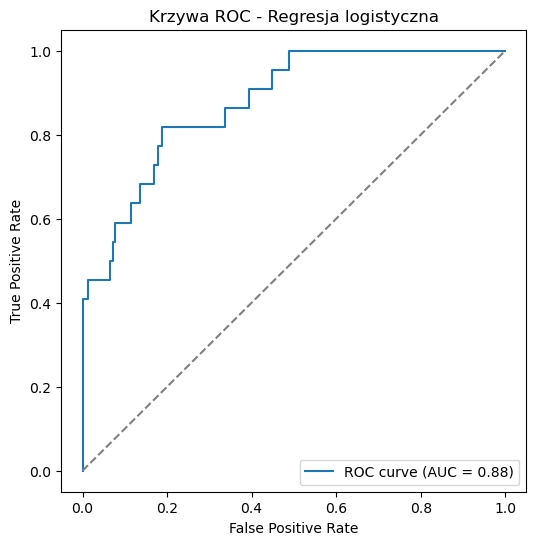

In [25]:
# Tworzenie i trenowanie modelu z uwzględnieniem nierównomiernych klas
logreg = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
logreg.fit(X_train, y_train)

# Predykcje na zbiorze testowym
y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:,1]  # prawdopodobieństwo dla klasy 1

# Metryki
print("Dokładność (Accuracy):", accuracy_score(y_test, y_pred))
print("Precyzja (Precision):", precision_score(y_test, y_pred, zero_division=0))
print("Czułość / Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
print("Macierz pomyłek:\n", cm)

# Krzywa ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC - Regresja logistyczna')
plt.legend(loc='lower right')
plt.show()

Dokładność (Accuracy): 0.8796680497925311
Precyzja (Precision): 0.40540540540540543
Czułość / Recall: 0.6818181818181818
F1-score: 0.5084745762711864
Macierz pomyłek:
 [[197  22]
 [  7  15]]


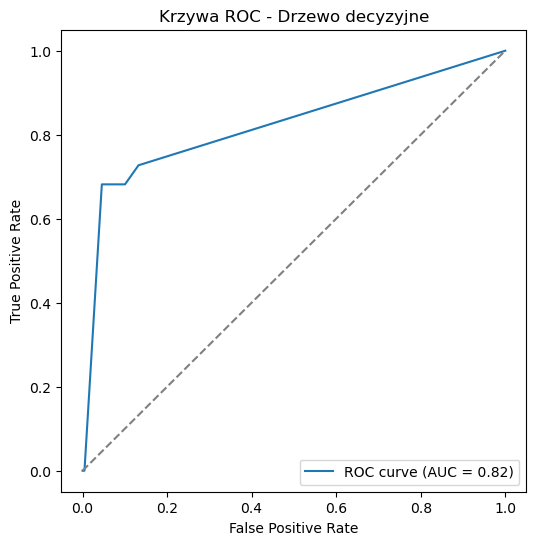

In [26]:
# Tworzenie i trenowanie drzewa decyzyjnego
dtree = DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=5)
dtree.fit(X_train, y_train)

# Predykcje
y_pred = dtree.predict(X_test)
y_pred_prob = dtree.predict_proba(X_test)[:,1]

# Metryki
print("Dokładność (Accuracy):", accuracy_score(y_test, y_pred))
print("Precyzja (Precision):", precision_score(y_test, y_pred, zero_division=0))
print("Czułość / Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
print("Macierz pomyłek:\n", cm)

# Krzywa ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC - Drzewo decyzyjne')
plt.legend(loc='lower right')
plt.show()



Random Forest - Dokładność (Accuracy): 0.941908713692946
Precyzja (Precision): 0.7
Czułość / Recall: 0.6363636363636364
F1-score: 0.6666666666666666
Macierz pomyłek:
 [[213   6]
 [  8  14]]


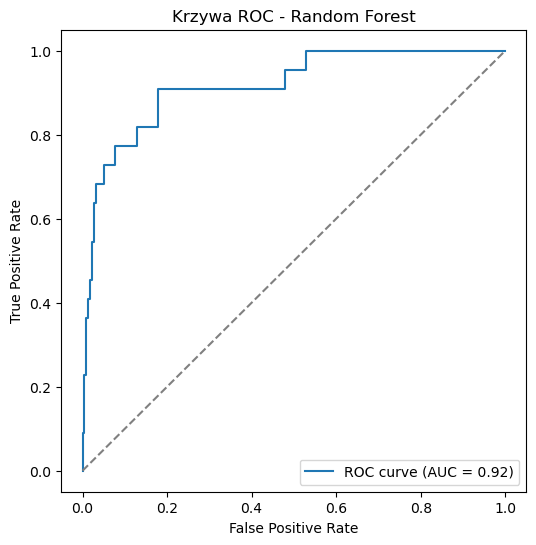

In [27]:
# Tworzenie i trenowanie Random Forest
rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=200, max_depth=7)
rf.fit(X_train, y_train)

# Predykcje
y_pred_rf = rf.predict(X_test)
y_pred_prob_rf = rf.predict_proba(X_test)[:,1]

# Metryki
print("Random Forest - Dokładność (Accuracy):", accuracy_score(y_test, y_pred_rf))
print("Precyzja (Precision):", precision_score(y_test, y_pred_rf, zero_division=0))
print("Czułość / Recall:", recall_score(y_test, y_pred_rf))
print("F1-score:", f1_score(y_test, y_pred_rf))

# Macierz pomyłek
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Macierz pomyłek:\n", cm_rf)

# Krzywa ROC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(6,6))
plt.plot(fpr_rf, tpr_rf, label='ROC curve (AUC = %0.2f)' % roc_auc_rf)
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC - Random Forest')
plt.legend(loc='lower right')
plt.show()


In [28]:
!pip install xgboost

Dokładność (Accuracy): 0.91701244813278
Precyzja (Precision): 0.5454545454545454
Czułość / Recall: 0.5454545454545454
F1-score: 0.5454545454545454
Macierz pomyłek:
 [[209  10]
 [ 10  12]]


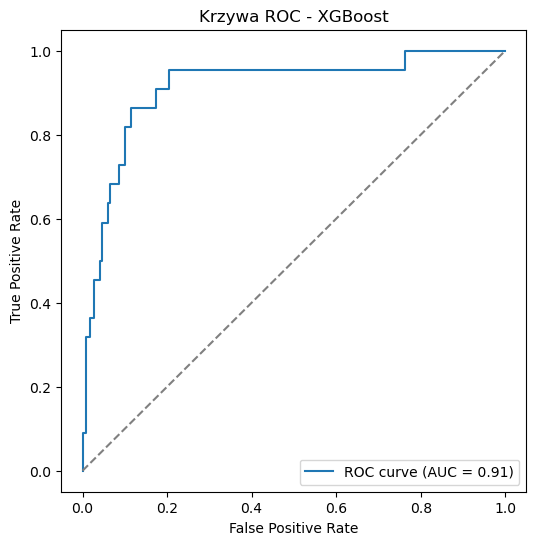

In [29]:
# Tworzenie XGBoost
xgb_model = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=(y_train==0).sum() / (y_train==1).sum()
)

# Trenowanie modelu
xgb_model.fit(X_train, y_train)

# Predykcje na zbiorze testowym
y_pred = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)[:,1]

# Metryki
print("Dokładność (Accuracy):", accuracy_score(y_test, y_pred))
print("Precyzja (Precision):", precision_score(y_test, y_pred, zero_division=0))
print("Czułość / Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
print("Macierz pomyłek:\n", cm)

# Krzywa ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC - XGBoost')
plt.legend(loc='lower right')
plt.show()



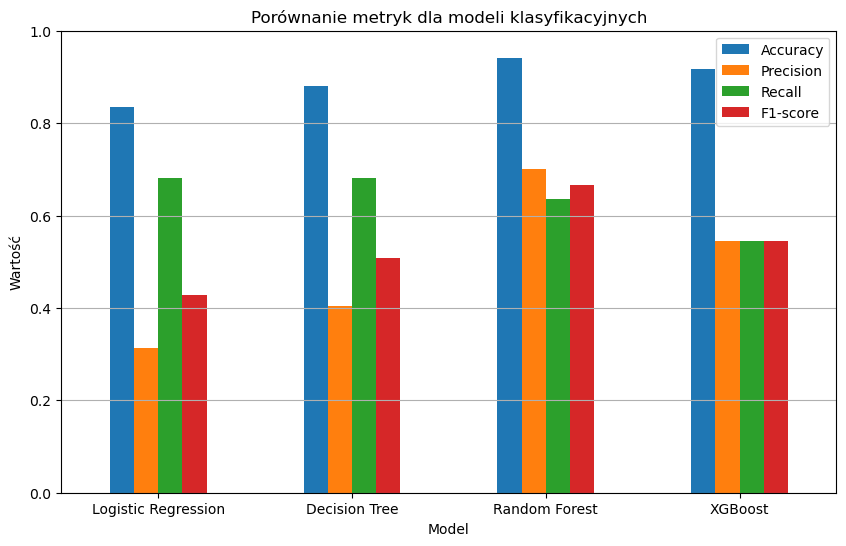

In [30]:
# Porownanie modeli
# Dane modeli
metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy': [0.834, 0.880, 0.942, 0.917],
    'Precision': [0.3125, 0.405, 0.7, 0.545],
    'Recall': [0.682, 0.682, 0.636, 0.545],
    'F1-score': [0.429, 0.508, 0.667, 0.545]
})

# Wykres
metrics_df.set_index('Model').plot(kind='bar', figsize=(10,6))
plt.title("Porównanie metryk dla modeli klasyfikacyjnych")
plt.ylabel("Wartość")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


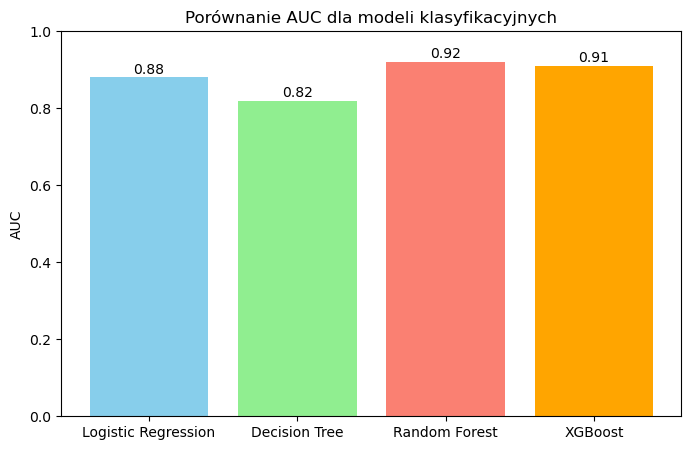

In [31]:
# Porownanie modeli
# Dane AUC
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
auc_scores = [0.88, 0.82, 0.92, 0.91]

# Wykres
plt.figure(figsize=(8,5))
plt.bar(models, auc_scores, color=['skyblue','lightgreen','salmon','orange'])
plt.ylim(0,1)
plt.ylabel("AUC")
plt.title("Porównanie AUC dla modeli klasyfikacyjnych")
for i, v in enumerate(auc_scores):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')
plt.show()


Analiza wyników czterech modeli klasyfikacyjnych pokazuje, że w kontekście przewidywania niespłaconych pożyczek kluczowy jest recall dla klasy niespłacona pożyczka. 
Regresja logistyczna osiągnęła recall 0.68 przy precyzji 0.31 i F1-score 0.43, co oznacza, że wychwyciła większość niespłaconych pożyczek, ale z dużą liczbą fałszywych alarmów. 
Drzewo decyzyjne miało podobny recall 0.68, nieco wyższą precyzję 0.41 i F1-score 0.51, co wskazuje na lepszą równowagę między wykrywalnością a dokładnością. 
Random Forest uzyskał najlepsze ogólne wyniki: recall 0.64, precyzję 0.70 i F1-score 0.67 przy wysokiej dokładności 0.94 i AUC 0.92, pokazując, że model dobrze identyfikuje niespłacone pożyczki i ogranicza fałszywe alarmy. 
XGBoost osiągnął recall 0.55, precyzję 0.55 i F1-score 0.55 przy dokładności 0.92 i AUC 0.91, co czyni go również solidnym modelem, choć mniej skutecznym w wychwytywaniu wszystkich niespłaconych pożyczek w porównaniu do Random Forest i drzew decyzyjnych. 
Widać wyraźnie, że modele oparte na lasach drzew (Random Forest, XGBoost) oferują lepszą stabilność i ogólną skuteczność, podczas gdy proste modele dobrze sprawdzają się w wychwytywaniu klasy niespłacona pożyczka, ale kosztem większej liczby fałszywych alarmów.

Najważniejsze cechy:
Modele wskazują, że największy wpływ na niespłacenie pożyczki mają cechy związane z aktywnością finansową klienta: całkowita kwota transakcji (total_trans_amount) i średnia kwota transakcji (avg_trans_amount). Wysokość płatności (payments) również jest istotna, co sugeruje, że klienci z wyższymi lub nieregularnymi płatnościami częściej zalegają ze spłatą. Wiek klienta (age_at_loan) i średnia pensja (Average Salary) mają niewielki wpływ, co pokazuje, że sytuacja finansowa i nawyki płatnicze są ważniejsze niż sam wiek czy dochód. Kategorie takie jak region i płeć mają wpływ marginalny, ale mogą w pewnym stopniu pomagać modelowi w drobnych niuansach predykcji.

Czynniki wpływające na niespłatę:
Klienci, którzy dokonują dużych transakcji lub mają wyższe płatności w stosunku do swojego profilu finansowego, są bardziej narażeni na zaległości. Niespłacenie pożyczki nie jest wyraźnie związane z wiekiem lub średnią pensją, ale bardziej z historią transakcji i wzorcami spłat. Z analizy korelacji wynika, że zmienne finansowe są głównymi czynnikamiryzyka.

Możliwości ulepszenia modelu:
Model można poprawić poprzez inżynierię cech, np. wprowadzając wskaźniki typu: stosunek całkowitych transakcji do średniej pensji, średnią miesięczną kwotę transakcji, liczbę wcześniejszych pożyczek lub opóźnienia w spłatach w historii klienta. Dalsze dostrojenie hiperparametrów w Random Forest i XGBoost (np. liczba drzew, głębokość, learning rate) może poprawić recall, który jest kluczowy przy wykrywaniu niespłaconych pożyczek, oraz zwiększyć F1-score, utrzymując przy tym dobrą precyzję.

Praktyczne zastosowanie:
Taki model może wspierać banki w ocenie ryzyka kredytowego, pozwalając na wcześniejsze identyfikowanie klientów zagrożonych niespłatą. Może być wykorzystany w decyzjach kredytowych – np. do ustalania limitów pożyczki, harmonogramu spłat lub wymagań zabezpieczeń. Dodatkowo, analiza cech pomaga zrozumieć, które elementy profilu klienta mają największy wpływ na ryzyko, co może wspierać strategie prewencyjne i doradcze w bankowości.